# Base the lineair regression example on:

https://www.tensorflow.org/tutorials/keras/regression

In [21]:
import keras
import pandas as pd
import seaborn as sns
import numpy as np
from tensorflow import keras
from plotnine import *

In [6]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

mtcars = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)
mtcars.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [208]:
mtcars.to_csv('mtcars.csv', index=False)

In [212]:
gg = (
    ggplot(mtcars) + geom_point(aes(x='Weight', y='MPG'))
)
ggsave(gg, 'scatterplot.png', dpi=200)

/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: scatterplot.png


# Normalize data
This is needed, Keras becomes very unstable without it. 

In [206]:
from tensorflow.keras.layers import Normalization

# This needs to be added in front, or the solution will be very unstable
normalizer = Normalization(input_shape=[1,], axis=None)
normalizer.adapt(mtcars['Weight'])

mtcars['Weight_norm'] = np.array(normalizer(mtcars['Weight'])).flatten()

In [181]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(mtcars, test_size=0.1)
train_data.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin,Weight_norm
181,33.0,4,91.0,53.0,1795.0,17.5,75,3,-1.389757
245,36.1,4,98.0,66.0,1800.0,14.4,78,1,-1.383845
137,13.0,8,350.0,150.0,4699.0,14.5,74,1,2.043772
257,19.4,6,232.0,90.0,3210.0,17.2,78,1,0.283261
7,14.0,8,440.0,215.0,4312.0,8.5,70,1,1.586204


# Keras neural network

In [188]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense

keras_mpg_weight = keras.Sequential([ 
    Input(shape=(1,)), 
    Dense(units=1)
])

keras_mpg_weight.compile(
    optimizer=Adam(learning_rate=0.1),
    loss='mean_squared_error')

history = keras_mpg_weight.fit(
    train_data['Weight_norm'], train_data['MPG'],
    epochs=100, verbose=0, validation_split = 0.2)

keras_mpg_weight.get_weights()

[array([[-6.4612894]], dtype=float32), array([23.748787], dtype=float32)]

# Statsmodels linear regression

In [189]:
from statsmodels.formula.api import ols

train_data['Weight_norm'] = np.array(normalizer([train_data['Weight']])).flatten()
ols_mpg_weight=ols("MPG ~ Weight_norm", data=train_data).fit()
ols_mpg_weight.params

Intercept      23.507012
Weight_norm    -6.466620
dtype: float64

# Comparison

/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: residualplot.png


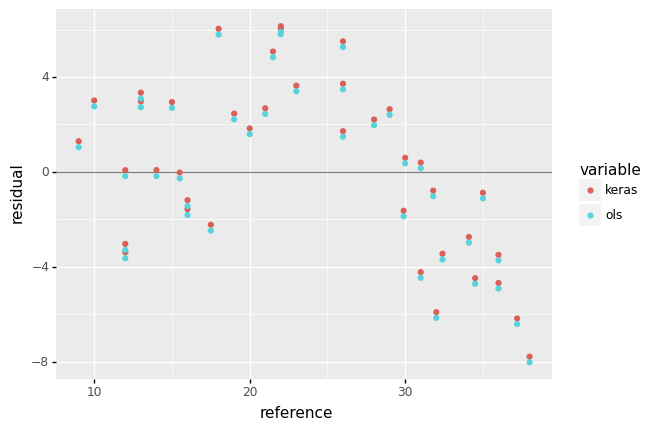

<ggplot: (8737291776549)>

In [214]:
from plotnine import *

prediction_results = pd.DataFrame({'keras'     : keras_mpg_weight.predict(test_data['Weight_norm']).flatten(),
                                   'ols'       : ols_mpg_weight.predict(test_data['Weight_norm']),
                                   'reference' : test_data['MPG']})

plot_data = (
    prediction_results
      .melt(id_vars='reference')
      .assign(residual = lambda x: x['value'] - x['reference'])
)

gg = (
    ggplot(plot_data) 
      + geom_hline(aes(yintercept = 0), alpha = 0.5)
      + geom_point(aes(x='reference', y='residual', color='variable')) 
)

ggsave(gg, 'residualplot.png', dpi=200)
gg